# Quantum unary approach to option pricing
***

### _Abstract_

Here is presented a novel quantum algorithm for European option pricing in finance, where the key idea is to work in the unary representation. The algorithm is divided in two main parts, amplitude distribution using a low depth circuit and computation of the expected return computed with simple controlled gates. Unary representation offers several advantages and one disadvantage. On the positive side, unary representation simplifies the structure and depth of the quantum circuit and also provides a post-selection consistency check that allows for a substantial mitigation in the error of the computation. On the negative side, unary representation offers lower resolution given a fixed number of qubits, as compared to binary algorithms.

In the following the unary algorithm is described and simulations are perfomed with the inclusion of a simple noise model in order to test the robustness of the algorithm

### Introduction

The use of quantum computation to solve financial problems, such as pricing of financial derivatives, is being discussed more and more nowadays [[1](https://arxiv.org/abs/1807.03890)], [[2](https://arxiv.org/abs/1805.00109)], [[3](https://arxiv.org/abs/1905.02666)]. Algorithms that estimate the expected payoff of a derivative have been recently presented, and the expectation is that, provided a robust quantum device, they will outclass current classical means. However, for Noisy Intermediate Scale Quantum (NISQ) devices currently available, these algorithms are too costly to run at high scales.

One of the most promising advantages provided by quantum computation is the exponential Hilbert space at its disposal. In the case of option pricing this directly translates to high precision in its estimations. However, the circuits that load the expected probabilities, and more importantly, the comparator needed to gauge if the option price is higher or lower than the accorded strike quickly becomes prohivitive in NISQ devices.

Here, a different point of view is proposed. Changing to the unary representation yields a simpler circuit and allows a post-selection scheme that results in error mitication. The unary representation means states where only a single qubit is in the $|1\rangle$ state. This represents a loss of Hilbert space of $2^n\longrightarrow n$, but is beneficial in other fronts. This allows for a simple amplitude distribution algorithm to encode the probability distriution of the asset price into the quantum register, and a more straight forward way to compute the expected payoff.

#### Pricing of European options

European options, known also as path-independent _vanilla_ options are the some of the easiest to approach at first. This is due to the fact that they only depend on the asset price at maturity time $T$, refrenced henceforth as $S_T$. The expected value of said asset at time $T$ can be evaluated via the Black-Scholes model [[4](http://www.jstor.org/stable/1831029)]. The Black-Scholes model assumes that the price of the asset underlying the option is dictated by a geometric Brownian motion. The evolution of the stock price can be described by the stochastic differential equation

$$dS_t=S_t r dt+S_t\sigma dW_t,$$

where $r$ and $\sigma$ are the interest rate and volatility of the asset and $W_t$ characterizes a Brownian motion. This Brownian motion can also be written as $dW_t=\sqrt{dt}N(0,1)$ with $N(0,1)$ a normal distribution with $0$ mean and standard deviation of $1$. This stochastic equation can be solved exatly for constant interest rate and volatility as

$$S_t=S_0e^{\sigma W_t+(\alpha-\sigma^2/2)t}.$$

This is an exponential of a normal random variable, hidden in $W_t$, therfore the probability distribution function of $S_t$ will take on a _log-normal_ form. At a maturity time T the probability distribution function of the asset price becomes

$$p(S_T)=\frac{1}{S_T\sigma\sqrt{2\pi T}}\exp{\left(-\frac{(\ln S_T-(\alpha-\frac{\sigma^2}{2})T-\ln S_0)^2}{2\sigma^2T}\right)},$$

from which $(\alpha-\frac{\sigma^2}{2})T+\ln S_0)$ is usually given as $\mu$.


In [1]:
'''
Lognormal probability distribution function normalized for representation in finite intervals

'''
def log_normal(x, mu, sig, T):
    dx = x[1]-x[0]
    log_norm = 1 / (x * sig * np.sqrt(2 * np.pi * T)) * np.exp(- np.power(np.log(x) - mu, 2.) / (2 * np.power(sig, 2.) * T))
    f = log_norm*dx/(np.sum(log_norm * dx))
    return f

Once the probability distribution is computed the payoff of an European option can be defined as 

$$\text{payoff}(S_T)=\max(0,S_T-K)$$

for call options, and 

$$\text{payoff}(S_T)=\max(0,K-S_T)$$

for put options, where $K$ is the accorded strike price when the option was first aquired. An option provides the chance to buy ( _call_ ) or sell ( _put_ ) the underlying asset at the strike price $K$ at maturity time $T$. As it is not mandatory to do so, the option holder will not buy or sell the asset if there is no profit to be made.

#### Difficulties for NISQ devices in the binary representation

Once the probability distribution function is succesfully uploaded into the binary representation, assumed to be efficient due to the integrability of the Black-Scholes model [[5](https://arxiv.org/abs/quant-ph/0208112)], in order to diferentiate states with $S_T>K$ ( _for call options_ ) a quantum comparator has to be implemented. This comparator [[6](https://arxiv.org/abs/quant-ph/0410184)], tailored to the strike price $K$, computes the carry bit in the most significant qubit to determine if the option price is above or below the strike. This procedure is based on multiple CNOT and Toffoli gates. Toffoli gates are a problem for NISQ devices as this three-quibit gates have to be decomposed to multiple single and two-qubit gates 

<img src="Images/Toffoli.png" width="600" title="Toffoli decomposition"/>

as seen in [7]. This makes the comparator hard to implement in near-term devices as the gates needed to complete the algorithm has a large decomposition in basis gates.

The unitary representation does not need of such a comparator, therefore no three qubit gate will be needed.

### Algorithm in the unary representation

#### Advantadges for NISQ devices

Unlike the binary case, there is no need of Toffoli gates for the comparator in the unary representation. At most, the most complicated gates that appear are CNOT and $cR_y$ gates. Overall, the probablity loading algorithm scales with $(n-1)$ partial-SWAP gates, where $n$ is the qubit number. If this number were to be decomposed into regular CNOT and single qubit gates, we would find $4(n-1)$ CNOT gates and $(2n-1)$ single qubit gates.

The payoff circuit is even simpler. Instead of relying on a comparator and a payoff calculator, in the unary representation they can be applied at the same time with $(n-k)$ $cR_y$ gates, where $k$ refers to the qubit number where the option price becomes higher than the strike. Therefore, the number of $cR_y$ gates needed is always lower than the number of qubits, sometimes significantly so.

The exact decomposition of the partial-SWAP gates and $cR_y$ gates will be shown in the following sections.

#### Amplitude distribution algorithm

This algorithm distributes the mplitude of one qubit with the rest in order to represent a target probability distribution. The circuit is initialized with only the middle qubit occupied. We can introduce partial-SWAP gates
<img src="Images/SWAPRy2.png" width="200" title="SWAP-Ry"/>
which can be decomposed as
<img src="Images/SWAPRy.png" width="250" title="SWAP-Ry decomposition"/>
using only CNOT and $cR_y$ gates. In turn, in order to represent it in the native gates of the device, this $cR_y$ gate can be separated into
<img src="Images/CRyDef.png" width="300" title="C-Ry decomposition"/>

The purpose of this two qubit gates is to share the probability of a state with its neighbours. The angle in which the rotation is performed encodes the amount of probability that leaves the occupied state to go to the next one. As this parameters can be trained or tuned analytically, one only needs one of this gates for each two qubit pair of the system, amounting to $(n-1)$ partial-SWAP gates. The completed amplitude distributor circuit for $n$ qubits is
<img src="Images/Prob_text.png" width="600" title="Random walk circuit"/>
where the gates are applied starting from the centre, as it is the only occupied state when the algorithm starts.

After this circuit is applied one finds the desired distribution encoded into the amplitudes of the system as
$$|\Psi\rangle=\sum_i^n\sqrt{p_i}|q_i\rangle.$$

In [2]:
'''
Circuit that emulates the probability sharing between neighbors seen usually
in Brownian motion and stochastic systems

'''
def rw_circuit(qubits, parameters):
    C = QuantumCircuit(qubits+1)
    if qubits%2==0:
        mid1 = int(qubits/2)
        mid0 = int(mid1-1)
        C.x(mid1)
        #partial-SWAP gates
        #-------------------------------------------------
        C.cx(mid1, mid0)
        C.cu3(parameters[mid0], 0, 0, mid0, mid1)
        C.cx(mid1, mid0)
        #-------------------------------------------------
        for i in range(mid0):
            #partial-SWAP gates
            #-------------------------------------------------
            C.cx(mid0-i, mid0-i-1)
            C.cu3(parameters[mid0-i-1], 0, 0, mid0-i-1, mid0-i)
            C.cx(mid0-i, mid0-i-1)
            #-------------------------------------------------
            C.cx(mid1+i, mid1+i+1)
            C.cu3(parameters[mid1+i], 0, 0, mid1+i+1, mid1+i)
            C.cx(mid1+i, mid1+i+1)
            #-------------------------------------------------
    else:
        mid = int((qubits-1)/2) #The random walk starts from the middle qubit
        C.x(mid)
        for i in range(mid):
            #partial-SWAP gates
            #-------------------------------------------------
            C.cx(mid-i, mid-i-1)
            C.cu3(parameters[mid-i-1], 0, 0, mid-i-1, mid-i)
            C.cx(mid-i, mid-i-1)
            #-------------------------------------------------
            C.cx(mid+i, mid+i+1)
            C.cu3(parameters[mid+i], 0, 0, mid+i+1, mid+i)
            C.cx(mid+i, mid+i+1)
            #-------------------------------------------------
    return C

##### Parameter optimization

Each parameter of the partial-SWAP gates for the random walk circuit can be solved exactly if the probability distribution function is analytic, as is the case in this example.

Due to the step-like nature of the circuit one can define a system of $n$ equations with $n-1$ free parameters to be fulfilled simultaneously. Then, starting from the edges of the circuit, one can start solving the equations. Once the center qubit is reached the rest of necessary solutions can be computed directly, as shown in the following code.

In [3]:
'''
Solving for the exact angles for the random walk circuit that enables the loading of
a desired probability distribution function

'''
def rw_parameters(qubits, pdf):
    if qubits%2==0:
        mid = int((qubits)/2)
    else:
        mid = int((qubits-1)/2) #Important to keep track of the centre
    last = 1
    parameters = []
    for i in range(mid-1):
        angle = 2 * np.arctan(np.sqrt(pdf[i]/(pdf[i+1] * last)))
        parameters.append(angle)
        last = (np.cos(angle/2))**2 #The last solution is needed to solve the next one
    angle = 2 * np.arcsin(np.sqrt(pdf[mid-1]/last))
    parameters.append(angle)
    last = (np.cos(angle/2))**2
    for i in range(mid, qubits-1):
        angle = 2 * np.arccos(np.sqrt(pdf[i]/last))
        parameters.append(angle)
        last *= (np.sin(angle/2))**2
    return parameters

In [4]:
'''
Circuit to sample the created probability distribution funtion

'''
def measure_probability(qubits):
    C = QuantumCircuit(qubits+1, qubits)
    C.barrier(qubits)
    C.measure(range(qubits),range(qubits)) #No measure on the ancilla qubit is necessary
    return C

In [5]:
'''
From the retuned sampling, extract only probabilies of unary states

'''
def extract_probability(qubits, counts, samples):
    form = '{0:0%sb}' % str(qu)
    prob = []
    for i in range(qu):
        prob.append(counts.get(form.format(2**i), 0))
    prob = np.array(prob)
    prob = prob/sum(prob)
    return prob

In [6]:
def extract_probability_all_samples(qubits, counts, samples):
    """
    From the retuned sampling, extract only probabilies of all states
    """
    form = '{0:0%sb}' % str(qubits)
    prob = []
    for i in range(2**qubits):
        prob.append(counts.get(form.format(i), 0))
    prob = np.array(prob)
    prob = prob/sum(prob)
    return prob

***

###### Simulation

In order to test that this first step of the algorithm is correct, we can run a simulation using _qasm_simulator_

In [7]:
'''
Import auxiliary packages

'''
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from math import pi

In [8]:
'''
Import Qiskit packages

'''
from qiskit import QuantumCircuit, execute
from qiskit import Aer

In [9]:
'''
Get qasm backend for the simulation of the circuit

'''
backend_sim = Aer.get_backend('qasm_simulator')

In [10]:
'''
Define all the parameters to be used in the computation

'''
qu = 8 #Number of qubits for the probability distribution (ancilla not included)
S0 = 2
K = 1.9
sig = 0.4
r = 0.05
T = 0.25
mu = (r-0.5*sig**2)*T+np.log(S0) #mu value to be fed to lognormal distribution
samples = 10000

In order to sucesfully plot our data, it is useful to get the mean and variance of the log-normal probability distribution. The distance of 3 standard deviations from the mean is enough to represent the relevant part of the distribution.

In [11]:
'''
Set the relevant zone of study and create the mapping between qubit and option price, and
generate the target lognormal distribution within the interval

'''
mean = np.exp(mu+0.5*T*sig**2)
variance = (np.exp(T*sig**2)-1)*np.exp(2*mu+T*sig**2)

S = np.linspace(max(mean - 3 * np.sqrt(variance), 0), mean+3*np.sqrt(variance), qu)

ln = log_normal(S, mu, sig, T) 

In [12]:
'''
Solve for the parameters needed to create the target lognormal distribution

'''
lognormal_parameters = rw_parameters(qu, ln)

In [13]:
'''
Build the probaility loading circuit with the adjusted parameters

'''
prob_loading = rw_circuit(qu, lognormal_parameters)

In [14]:
'''
Circuit to test the precision of the probability loading algorithm

'''
circ_prob = prob_loading+measure_probability(qu)

In [15]:
'''
Run the test circuit through the simulator and sample the results
in order to get the estimated probabilities

'''
job_sim = execute(circ_prob, backend_sim, shots=samples)
result_sim = job_sim.result()

In [16]:
counts_sim = result_sim.get_counts(circ_prob)

In [17]:
prob_sim = extract_probability(qu, counts_sim, samples)

In [18]:
'''
Generate a very precise target probability distribution to benchmark the quantum results

'''
Sp = np.linspace(max(mean - 3 * np.sqrt(variance), 0), mean+3*np.sqrt(variance), 10000)
lnp = log_normal(Sp, mu, sig, T)

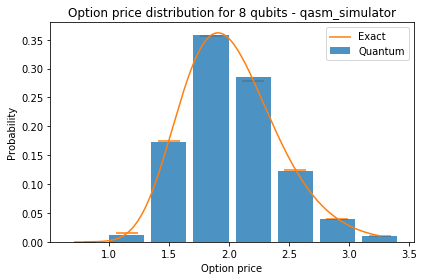

In [19]:
'''
Plot the probability of each unary state on the corresponding option price and
check against the precise classical probability drsitribution function for the 
target log-normal distribution

'''
width = (S[1]-S[0])/1.2

fig, ax = plt.subplots()
ax.bar(S, prob_sim, width, label='Quantum', alpha=0.8)
ax.scatter(S, ln, s=500, color='C1', label='Exact', marker='_')
ax.plot(Sp, lnp* (S[1]- S[0]) / (Sp[1] - Sp[0]), 'C1')
plt.ylabel('Probability')
plt.xlabel('Option price')
plt.title('Option price distribution for {} qubits - qasm_simulator'.format(qu))
ax.legend()
fig.tight_layout()

plt.show()

The simulation using the calculated exact parameters for the partial-SWAP gate yields a good approximation of the target lognormal distribution. Therefore, we can keep going and apply the expected payoff calculator to this result.
***

#### Expected payoff calculator

Once the probability distribution has been succesfully loaded, an ancilla is added to the system
$$|\Psi\rangle=\sum_i^n\sqrt{p_i}|q_i\rangle|0\rangle.$$
In order to encode the expected payoff into the probability of measuring $|1\rangle$ in the ancilliary qubit, one must first find the qubits that are mapped to asset prices above the strike $K$, as this example focuses on European _call_ options. In the unary case this is easy, as each qubit is mapped to an asset price. Therefore, the algorithm consists on applying $cR_y$ gates targetting the ancilla, controlled exclusively by qubits with an associated asset price that is higher than the strike $K$. This circuit, for $n$ qubits plus the ancilla, takes the form
<img src="Images/Payoff_text.png" width="600" title="Payoff circuit"/>

In order to finalize the circuit one must set the angles on the $cR_y$ gates to successfully encode the expected payoff. In this case, each angle will be
$$\theta_i=2\arcsin{\sqrt{\frac{S_i-K}{S_n-K}}},$$
where the $S_n-K$ term is set for normalization purposes. After the circuit is applied, the final state of the quantum system will be
$$|\Psi\rangle=\sum_{i<K}^n\sqrt{p_i}|q_i\rangle|0\rangle+\sum_{i>K}^n\sqrt{p_i}\cos{\frac{\theta_i}{2}}|q_i\rangle|0\rangle+\sum_{i>K}^n\sqrt{p_i}\sin{\frac{\theta_i}{2}}|q_i\rangle|1\rangle.$$
Which results in a probability of measuring $|1\rangle$ in the ancilla of
$$P(|1\rangle) = \sum_{S_i > K} p_i \frac{S_i - K}{S_{max} - K},$$
where the expected payoff can be extracted by removing the normalization piece.

In [20]:
'''
Circuit that codifies the expected payoff of the option into the probability of a
single ancilla qubit

'''
def payoff_circuit(qubits, K, S):
    C = QuantumCircuit(qubits+1)
    for i in range(qubits): #Determine the first qubit's price that 
        qK = i              #surpasses the strike price
        if K<S[i]:
            break
    C.barrier(range(qubits+1))
    for i in range(qK, qubits):                              #Control-RY rotations controled by states
        angle = 2 * np.arcsin(np.sqrt((S[i]-K)/(S[qubits-1]-K))) #with higher value than the strike
        C.cu3(angle, 0, 0, i, qubits)                        #targeting the ancilla qubit
    return C

#### Error mitigation

Here is where the post-selection scheme appears. As the amplitude distributor works solely in a unary representation, if the read-out of any measurement of the first $n$ qubits contains more than one $|1\rangle$, there has been an error in the process. Therefore, that run can be discarded.

This simple post-selection scheme does, in fact, reduce the error of the outcome. 


In [21]:
'''
Circuit that measures the ancilla qubit to sample the expected payoff of the option

'''
def measure_payoff(qubits):
    '''
    Measuements needed for the post-selection step of the algorithm
    
    '''
    C = QuantumCircuit(qubits+1, qubits+1)
    C.measure(range(qubits+1), range(qubits+1))
    return C


#### Build the complete circuit

Now the complete circuit for expected payoff calculation can be concatenated together. The final circuit includes the probability loading algorithm for the unary representation and the payoff circuit. An example for a complete circuit for 7 qubits plus an ancilla.
<img src="Images/Total_text.png" width="800" title="Total circuit"/>

In [22]:
'''
Total circuit containing the probability loading and the payoff estimation measuring
the ancilla qubit.

'''
circ_payoff_sim = prob_loading + payoff_circuit(qu, K, S) + measure_payoff(qu)

###### Simulation

In [23]:
'''
Run the complete payoff expectation circuit through a simulator 
and sample the ancilla qubit

'''
job_payoff_sim = execute(circ_payoff_sim, backend_sim, shots=samples)
result_payoff_sim = job_payoff_sim.result()

In [24]:
counts_payoff_sim = result_payoff_sim.get_counts(circ_payoff_sim)

In [25]:
'''
Post-selection step where states that do not belong to the unary representation of
the asset value are discarded.

'''
ones=0
zeroes=0
for key in counts_payoff_sim.keys(): #Post-selection step
    unary = 0
    for i in range(1,qu+1):
        unary+=int(key[i])
    if unary==1:
        if int(key[0])==0:
            zeroes+=counts_payoff_sim.get(key)
        else:
            ones+=counts_payoff_sim.get(key)

qu_payoff_sim = ones * (S[qu - 1]-K) / (ones+zeroes)

In [26]:
'''
Calculation of the expected payoff using the precise probability distribution
computed classically

'''
cl_payoff = 0
for i in range(len(Sp)):
    if K<Sp[i]:
        cl_payoff += lnp[i]*(Sp[i]-K)

In [27]:
print('With precision {}'.format(samples))
print('Classical Payoff: {}'.format(cl_payoff))
print('')
print('With {} qubits and {} samples'.format(qu, samples))
print('Quantum Payoff: {}'.format(qu_payoff_sim))
print('')
print('Percentage off: {}%'.format(np.abs(100*(cl_payoff-qu_payoff_sim)/cl_payoff)))

With precision 10000
Classical Payoff: 0.21755186788182482

With 8 qubits and 10000 samples
Quantum Payoff: 0.22465089021855428

Percentage off: 3.2631401448530344%


___Results:___ 

Even with an exponential loss of precision, it seems that the final result for the expected payoff does not differ much from the precise value computed by classical means.
***

In order to test the resiliance of the algorithm under noise, we could run it through a real quantum device. But if we want more control over the errors, we can define a noise model in order to run noisy simulations. 

In [28]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.providers.aer.noise.errors import pauli_error
from qiskit.providers.aer.noise import NoiseModel

In [29]:
'''
Build a noise model with tunable bitflip, phaseflip and measurement errors.

'''
def noise_model_total(qubits, t_bit, t_phase, t_meas):
    noise_model = NoiseModel()
    bit_error = t_bit
    phase_error = t_phase
    cnotb_error = 2*t_bit
    cnotp_error = 2*t_phase
    p_measure = t_meas
    bit_flip = pauli_error([('X', bit_error), ('I', 1 - bit_error)])
    phase_flip = pauli_error([('Z', phase_error), ('I', 1 - phase_error)])
    bitphase_flip = bit_flip.compose(phase_flip)
    cnot_bit = pauli_error([('X', cnotb_error), ('I', 1 - cnotb_error)])
    cnot_phase = pauli_error([('Z', cnotp_error), ('I', 1 - cnotp_error)])
    cnot_error = cnot_bit.compose(cnot_phase)
    cnot_error = cnot_error.tensor(cnot_error)
    noise_model.add_all_qubit_quantum_error(cnot_error, ['cx'], warnings=False)
    noise_model.add_all_qubit_quantum_error(bitphase_flip, ["u1", "u2", "u3"])
    measure_error = pauli_error([('X',p_measure), ('I', 1 - p_measure)])
    noise_model.add_all_qubit_quantum_error(measure_error, "measure")

    return noise_model

#### Noisy simulation 

In [30]:
circ_payoff_noise = prob_loading + payoff_circuit(qu, K, S) + measure_payoff(qu)

In [31]:
'''
Determine the noise model we want to use.

In this example: 0.3% bitflip and phaseflip errors
                 1% measurement error

'''
t_bit = 0.003
t_phase = 0.003
t_meas = 0.01

noise_model = noise_model_total(qu, t_bit, t_phase, t_meas)
basis_gates = noise_model.basis_gates

In [32]:
'''
Run the complete payoff expectation circuit through noisy simulation
following the determined noise model

'''
backend_noise = Aer.get_backend('qasm_simulator')
job_payoff_noise = execute(circ_payoff_noise, backend_noise, shots=samples, basis_gates=basis_gates, noise_model=noise_model)
result_payoff_noise = job_payoff_noise.result()

In [33]:
counts_payoff_noise = result_payoff_noise.get_counts(circ_payoff_noise)

In [34]:
'''
Post-selection step where states that do not belong to the unary representation of
the asset value are discarded.

'''
ones=0
zeroes=0

for key in counts_payoff_noise.keys():
    unary = 0
    for i in range(1,qu+1):
        unary+=int(key[i])
    if unary==1:
        if int(key[0])==0:
            zeroes+=counts_payoff_noise.get(key)
        else:
            ones+=counts_payoff_noise.get(key)

qu_payoff_post = ones * (S[qu - 1]-K) / (ones+zeroes)

In [35]:
'''
Result without the post-selection scheme

'''
ones=0
zeroes=0

for key in counts_payoff_noise.keys():
    if int(key[0])==0:
        zeroes+=counts_payoff_noise.get(key)
    else:
        ones+=counts_payoff_noise.get(key)

qu_payoff_no_post = ones * (S[qu - 1]-K) / (ones+zeroes)

In [36]:
print('With precision {}'.format(samples))
print('Classical Pay-off: {}'.format(cl_payoff))
print('')
print('Noise simulation with {}% bitflip, {}% phaseflip and {}% measurement errors:'.format(t_bit, t_phase, t_meas))
print('With precision {} qubits and {} samples'.format(qu, samples))
print('')
print('With post-processing')
print('')
print('Quantum Pay-off: {}'.format(qu_payoff_post))
print('')
print('Percentage off: {}%'.format(np.abs(100*(cl_payoff-qu_payoff_post)/cl_payoff)))
print('')
print('Without post-processing')
print('')
print('Quantum Pay-off: {}'.format(qu_payoff_no_post))
print('')
print('Percentage off: {}%'.format(np.abs(100*(cl_payoff-qu_payoff_no_post)/cl_payoff)))

With precision 10000
Classical Pay-off: 0.21755186788182482

Noise simulation with 0.003% bitflip, 0.003% phaseflip and 0.01% measurement errors:
With precision 8 qubits and 10000 samples

With post-processing

Quantum Pay-off: 0.2937883678863928

Percentage off: 35.04290758191972%

Without post-processing

Quantum Pay-off: 0.3646350391506456

Percentage off: 67.60832379923166%


The post-processing scheme reduced over 30% of the error found in this highly noisy simulation.

***

#### Summary

The unary representation may need a larger amount of qubits to reach the same precision than the binary scheme allows for. However, the simplicity of the unary circuit and the ability to post-select the outcomes to achieve error mitigation could make it ideal for NISQ devices.

### _References_

[1] R. Orus, S. Mugel and E. Lizaso, *Quantum computing for finance: overview and prospects*, Reviews in Physics 4 (2019) 100028, [arXiv:1807.03890](https://arxiv.org/abs/1807.03890). <br>

[2] P. Rebentrost, B. Gupt and T. R. Bromley, *Quantum computational finance: Monte Carlo pricing of financial derivatives*, Phys. Rev. A 98, 022321 (2018), [arXiv:1805.00109](https://arxiv.org/abs/1805.00109). <br>

[3] N. Stamatopoulos, D. J. Egger, Y. Sun, C. Zoufal, R. Iten, N. Shen and S. Woerner, *Option Pricing using Quantum Computers* (2019), [arXiv:1905.02666](https://arxiv.org/abs/1905.02666). <br>

[4] F. Black and M. Scholes, *The Pricing of Options and Corporate Liabilities*,  The Journal of Political Economy, Vol. 81, No. 3, pp. 637-654 (1973), [JSTOR](http://www.jstor.org/stable/1831029). <br>

[5] L. Grover and T. Rudolph, *Creating superpositions that correspond to efficiently integrable probability distributions* (2002), [arXiv:quant-ph/0208112](https://arxiv.org/abs/quant-ph/0208112). <br>

[6] S. A. Cuccaro, T. G. Draper, S. A. Kutin and D. Petrie Moulton, *A new quantum ripple-carry addition circuit* (2004), [arXiv:quant-ph/0410184](https://arxiv.org/abs/quant-ph/0410184). <br>

[7] M.A. Nielsen and I.L. Chuang, *Quantum computation and quantum information*, Cambridge UniversityPress (2010). <br>

In [37]:
import qiskit.tools.jupyter
%qiskit_version_table